### Libraries

In [1]:
#%reset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import modules and packages
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
from tqdm import tqdm
from numpy.linalg import norm
import matplotlib
import matplotlib.pyplot as plt

np.random.seed(2022)
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow import keras
from tensorflow.keras import layers


### Data Preprocessing

In [ ]:
# Data import
df = pd.read_excel('/content/drive/MyDrive/ColabWorks/LF_MultiHead/zone_demand.xlsx')
df = df.iloc[::-1]
df.reset_index(drop=True, inplace = True)
df["date"] = df["date"] + pd.Timedelta(days=1) #Shifting date by 1 day
print(df.shape)

(3234, 11)


In [ ]:
# checking the missing dates
pd.date_range(start = '2014-01-01', end = '2022-12-20' ).difference(df['date'].dt.date)

DatetimeIndex(['2014-02-11', '2014-02-26', '2014-03-12', '2014-03-22',
               '2014-03-23', '2014-04-03', '2014-04-04', '2014-04-05',
               '2014-04-11', '2014-04-12',
               ...
               '2021-06-05', '2021-06-11', '2021-08-31', '2021-09-30',
               '2021-10-02', '2021-11-16', '2022-01-04', '2022-06-14',
               '2022-09-04', '2022-11-23'],
              dtype='datetime64[ns]', length=115, freq=None)

In [ ]:
# Changing Reporting date column to date format
df.set_index('date',inplace=True)
df.index = pd.DatetimeIndex(df.index.date)
df.dropna(axis=0, inplace= True)
print(df.shape)

(3157, 10)


In [ ]:
df[df.index.duplicated()]

,Unnamed: 0,dhaka,chittagong,comilla,mymensingh,sylhet,khulna,rajshahi,barishal,rangpur


In [ ]:
# Filling missing dates 
idx= pd.date_range(start = '2014-01-01', end = '2022-12-20' )
df = df.reindex(idx)
print(df.shape)

(3276, 10)


In [ ]:
df.drop('Unnamed: 0', axis = 1, inplace = True)

# Interpolation
df.interpolate(method= 'time', inplace = True)

# reset columns index
df.reset_index(inplace = True)
df.rename(columns = {'index':'dates'}, inplace = True)

# Adding month column
df["month"] = pd.Series([i.month for i in df.dates])

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/ColabWorks/LF_MultiHead/zone_load.csv')
cols = np.array(df2.columns)[-9:]
df[cols] = df2[cols]

In [ ]:
#df.to_csv('/content/drive/MyDrive/ColabWorks/LF_MultiHead/demand_data.csv')

### Outlier Removal

<Axes: >

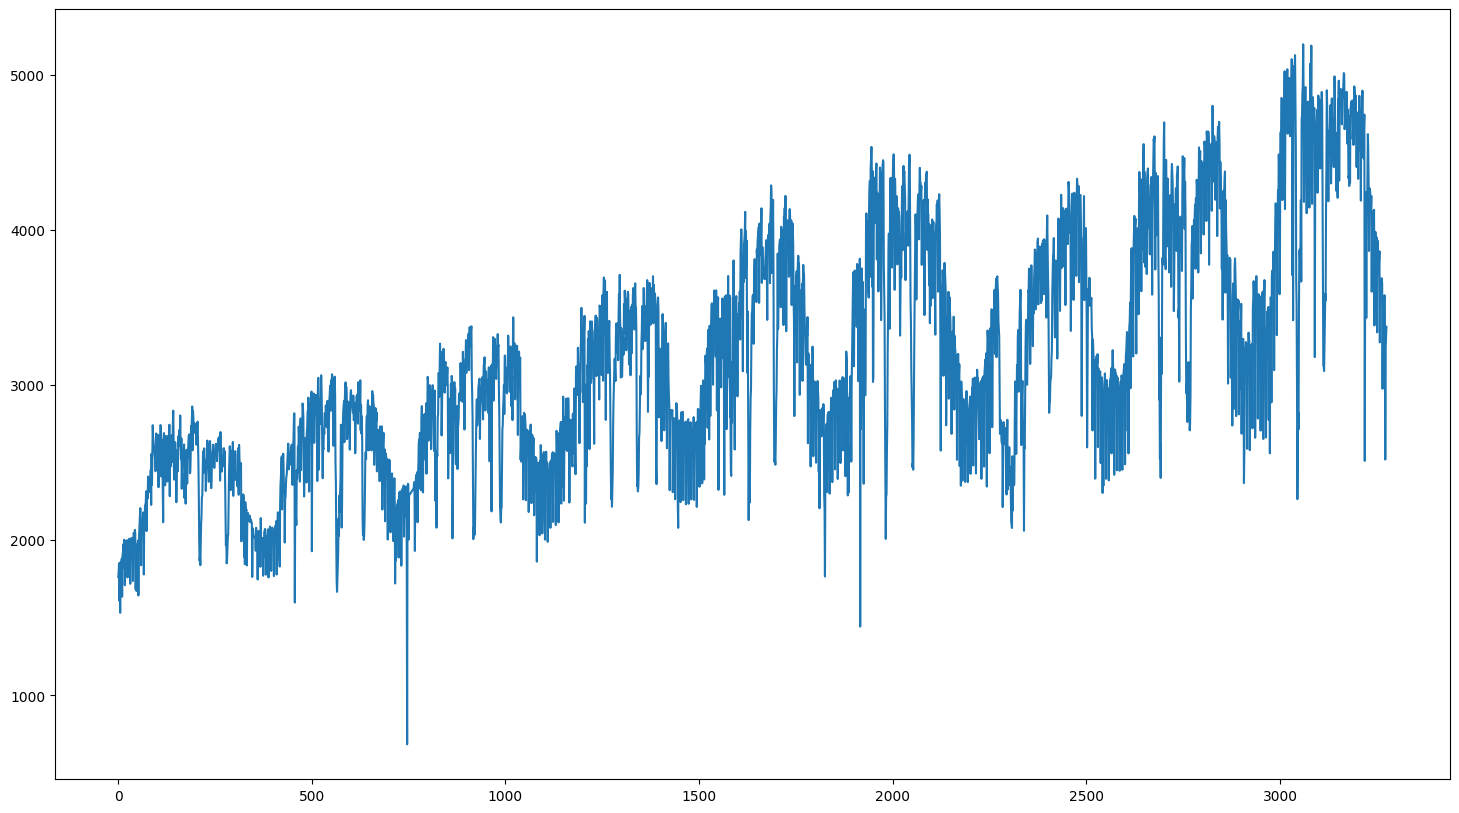

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ColabWorks/LF_MultiHead/demand_data.csv')
#df = pd.read_csv('/content/drive/MyDrive/ColabWorks/LF_MultiHead/demand_wo_humidity.csv')
df['dhaka'].plot(figsize = [18,10])

In [ ]:
# indexes for splitting data
k = 50
split = int(df.shape[0]/k)
idxs = [x*split for x in range(k+1)]
print(idxs)

[0, 65, 130, 195, 260, 325, 390, 455, 520, 585, 650, 715, 780, 845, 910, 975, 1040, 1105, 1170, 1235, 1300, 1365, 1430, 1495, 1560, 1625, 1690, 1755, 1820, 1885, 1950, 2015, 2080, 2145, 2210, 2275, 2340, 2405, 2470, 2535, 2600, 2665, 2730, 2795, 2860, 2925, 2990, 3055, 3120, 3185, 3250]


In [ ]:
def find_outliers_IQR(df_):
  q1=df_.quantile(0.25)
  q3=df_.quantile(0.75)
  IQR=q3-q1
  outliers = df_[((df_<(q1-1.5*IQR)) | (df_>(q3+1.5*IQR)))]
  return np.array(outliers.index), q1-1.5*IQR, q3+1.5*IQR

In [ ]:
outliers_index = {}
areas = ['dhaka', 'chittagong', 'comilla', 'mymensingh',
       'sylhet', 'khulna', 'rajshahi', 'barishal', 'rangpur']

for area in areas:
  outliers_in_area = []
  for i in range(k):
    indices, min, max = find_outliers_IQR(df[area][idxs[i]:idxs[i+1]])
    for j in indices:
      outliers_in_area.append(j)
  
  outliers_index[area] = outliers_in_area


In [ ]:
len(outliers_index['khulna'])

161

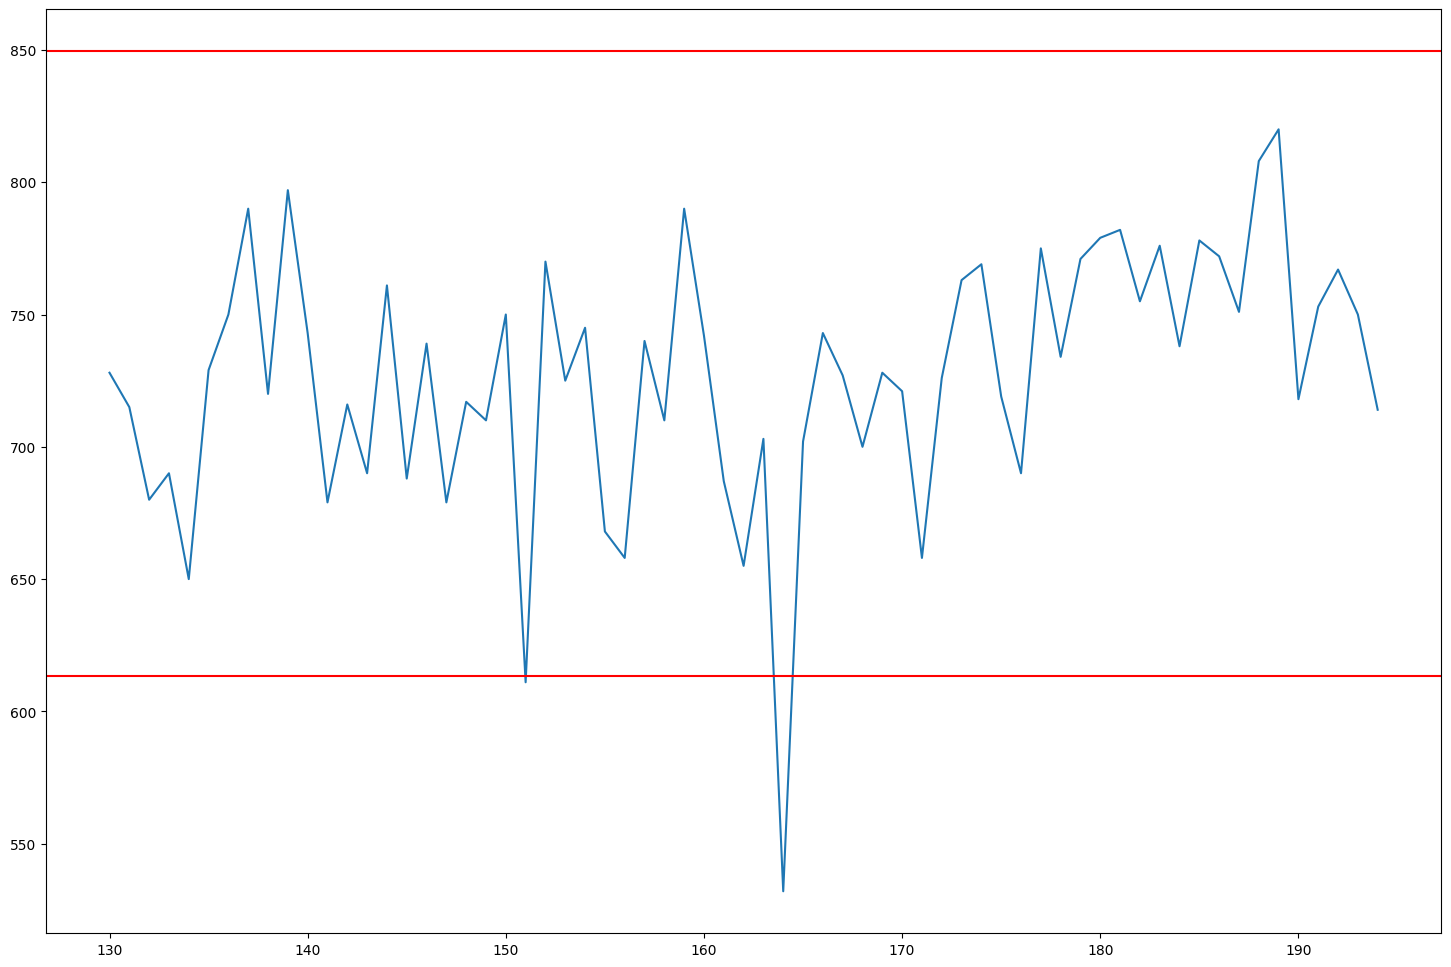

In [ ]:
# To Plot data for a certain split value and area
area = 'khulna'
i = 2
_ , min, max = find_outliers_IQR(df[area][idxs[i]:idxs[i+1]])

df[area][idxs[i]:idxs[i+1]].plot(figsize = [18,12])
plt.axhline(y=min, color='r', linestyle='-')
plt.axhline(y=max, color='r', linestyle='-')

In [ ]:
df2 = df.copy()

In [ ]:
weeks = 2
for area in areas:
  print('Division: ', area)
  for i in outliers_index[area]:
    avg = []
    prev_value = df.loc[i,area] 
    # past weeks
    for j in range(weeks):
      if (i-(j+1)*7) >= 0 and df.loc[i-(j+1)*7,area]:
        avg.append(df.loc[i-(j+1)*7,area])
    # future weeks
    for j in range(weeks):
      if (i+(j+1)*7) <= df.shape[0] and df.loc[i+(j+1)*7, area]:
        avg.append(df.loc[i+(j+1)*7, area])
  
    new_value = sum(avg)/len(avg)
    print('\t index = {}, prev_value : {}, new_value = {}'.format(i, prev_value,new_value))
    df.loc[i, area] = new_value

Division:  dhaka
	 index = 5, prev_value : 1532.0, new_value = 1954.0
	 index = 66, prev_value : 1779.0, new_value = 1973.1
	 index = 209, prev_value : 2006.0, new_value = 2534.75
	 index = 210, prev_value : 1868.0, new_value = 2560.0
	 index = 211, prev_value : 1896.0, new_value = 2596.75
	 index = 212, prev_value : 1839.0, new_value = 2593.75
	 index = 213, prev_value : 1976.0, new_value = 2534.625
	 index = 214, prev_value : 2106.0, new_value = 2563.0
	 index = 280, prev_value : 1851.0, new_value = 2557.25
	 index = 281, prev_value : 1883.0, new_value = 2527.75
	 index = 346, prev_value : 1763.0, new_value = 1939.875
	 index = 360, prev_value : 1747.0, new_value = 1889.21875
	 index = 374, prev_value : 1771.0, new_value = 1814.0546875
	 index = 381, prev_value : 1778.0, new_value = 1801.263671875
	 index = 388, prev_value : 1760.0, new_value = 1796.57958984375
	 index = 456, prev_value : 1598.0, new_value = 2542.25
	 index = 564, prev_value : 1742.0, new_value = 2597.25
	 index = 56

<Axes: >

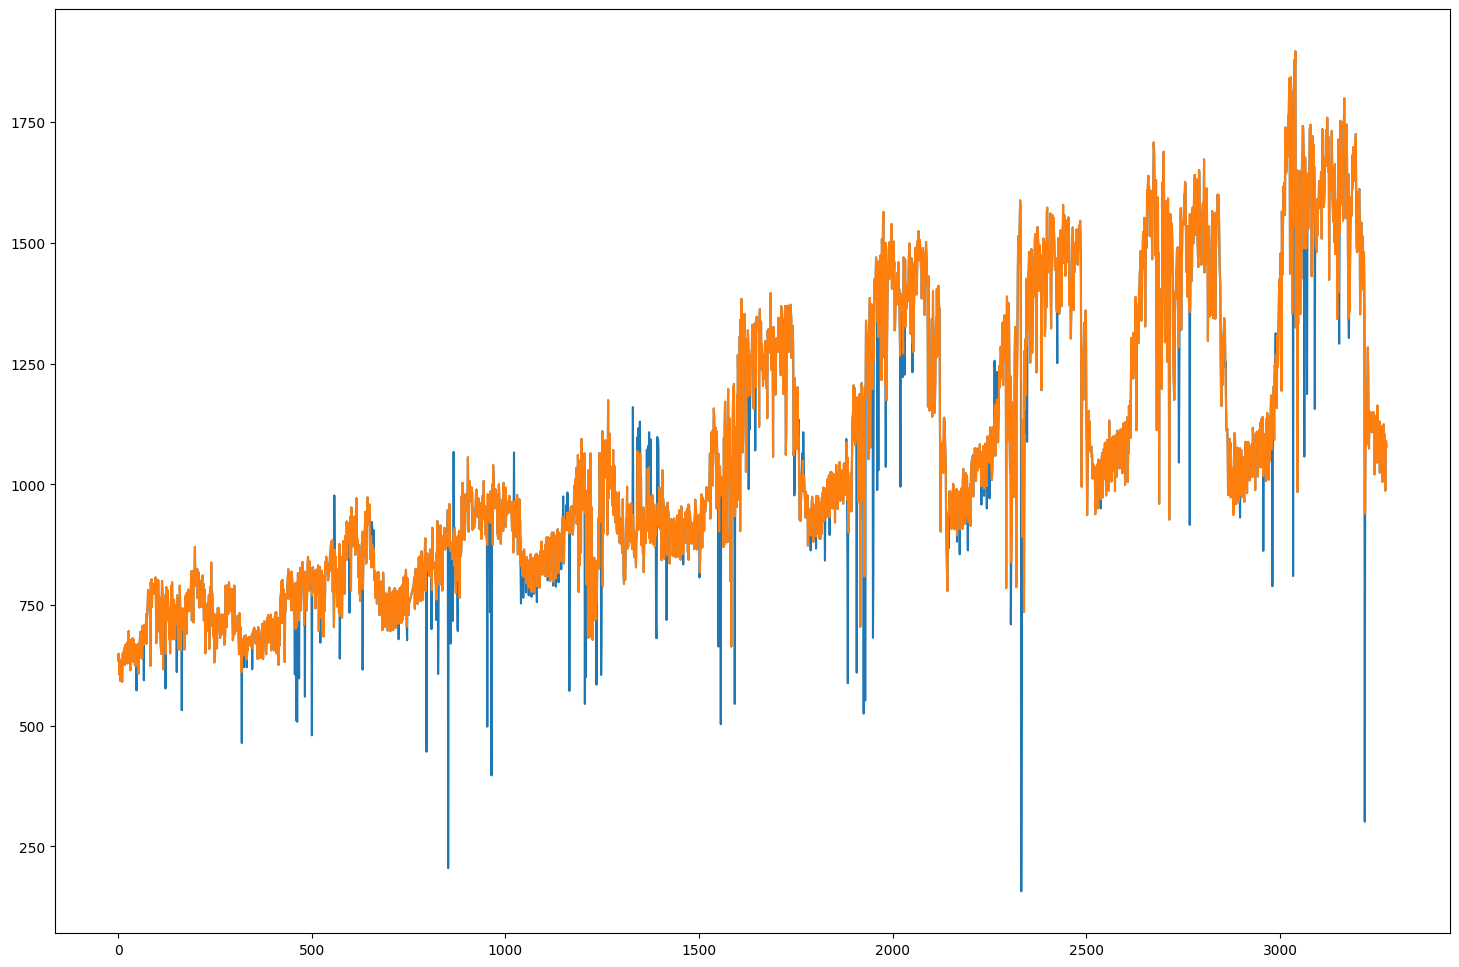

In [ ]:
area = 'khulna'
df2[area].plot(figsize = [18,12])
df[area].plot(figsize = [18,12])

In [ ]:
df.to_csv('/content/drive/MyDrive/ColabWorks/LF_MultiHead/demand_wo_outliers.csv')

### Data import


In [4]:
df = pd.read_csv('/content/drive/MyDrive/ColabWorks/LF_MultiHead/demand_wo_outliers.csv')
interpolation = False
gen = False
n_divs = 9
divs = ['dhaka', 'chittagong', 'comilla', 'mymensingh', 'sylhet', 'khulna', 'rajshahi', 'barishal', 'rangpur']

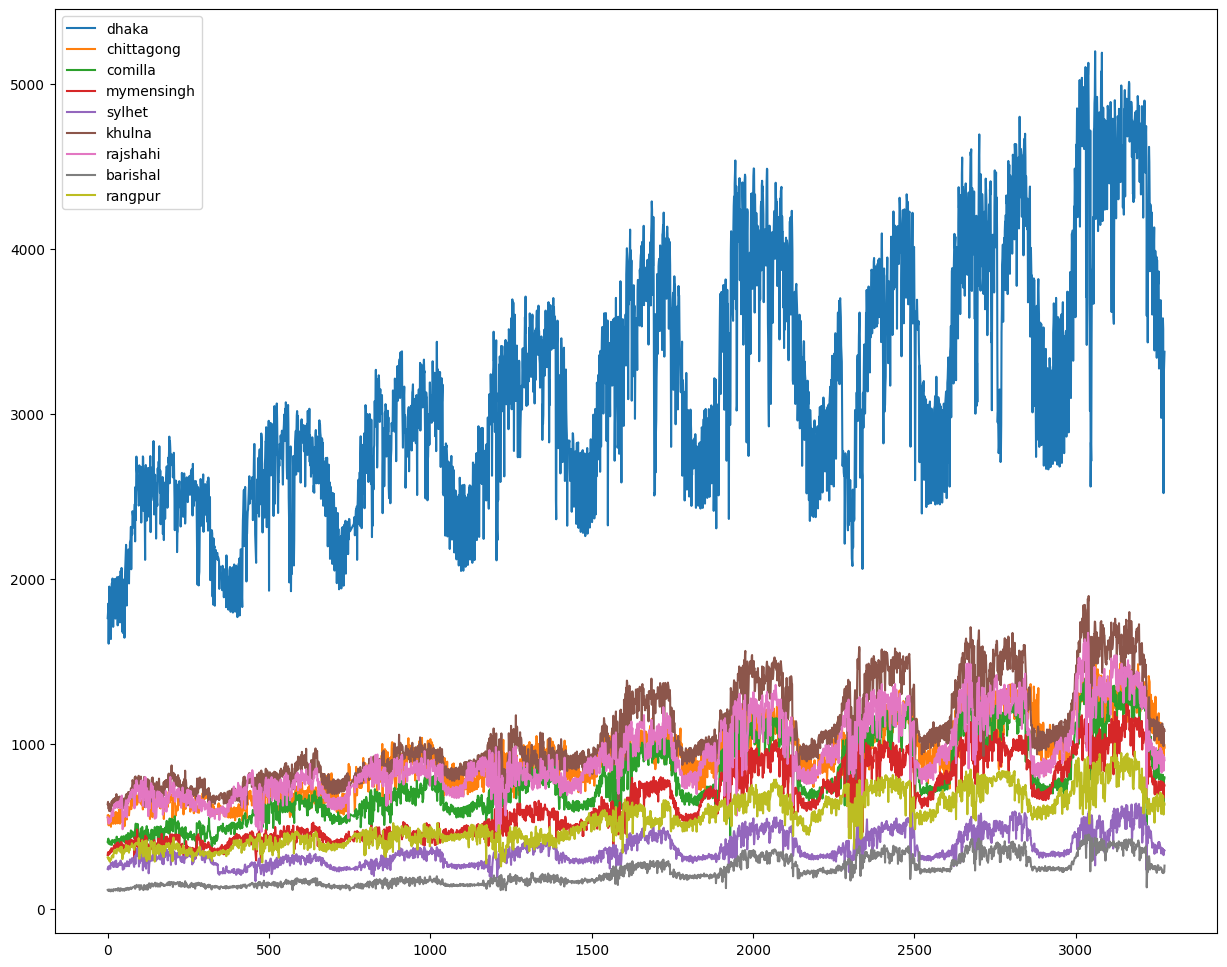

In [ ]:
plt.figure(figsize = (15,12))
plt.plot(df[divs], label = divs)
plt.legend()
plt.savefig('zone_demand.png', dpi = 500)
plt.show()

In [ ]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

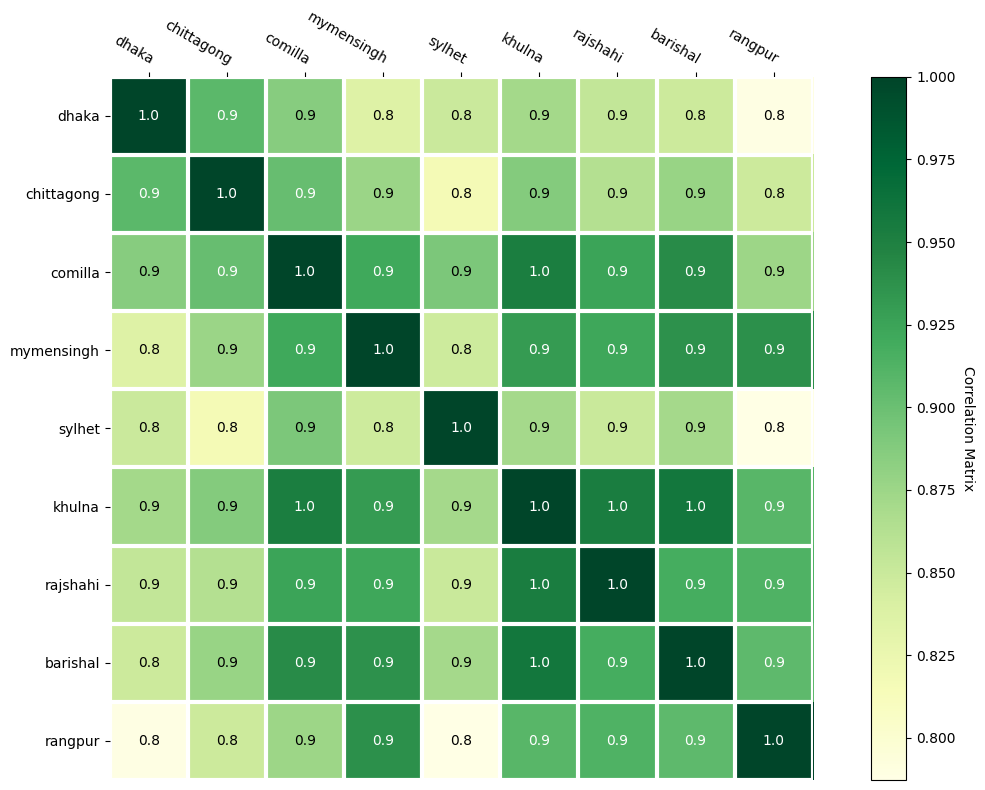

In [ ]:
## Correlation Among All division
columns = ['dhaka', 'chittagong', 'comilla', 'mymensingh',
       'sylhet', 'khulna', 'rajshahi', 'barishal', 'rangpur']

matrix = df[columns].corr()

fig, ax = plt.subplots(figsize = (12,8))

im, cbar = heatmap(matrix, columns, columns, ax=ax,
                   cmap="YlGn", cbarlabel="Correlation Matrix")
texts = annotate_heatmap(im, valfmt="{x:.1f}")

fig.tight_layout()
plt.savefig('corr_all_division.png', dpi = 500)
plt.show()

In [ ]:
df['dhaka_delayed_5'] = pd.Series(df['dhaka'][5:].values)
df['dhaka_delayed_10'] = pd.Series(df['dhaka'][10:].values)
df['dhaka_delayed_15'] = pd.Series(df['dhaka'][15:].values)
df['dhaka_delayed_20'] = pd.Series(df['dhaka'][20:].values)
df['dhaka_delayed_40'] = pd.Series(df['dhaka'][40:].values)

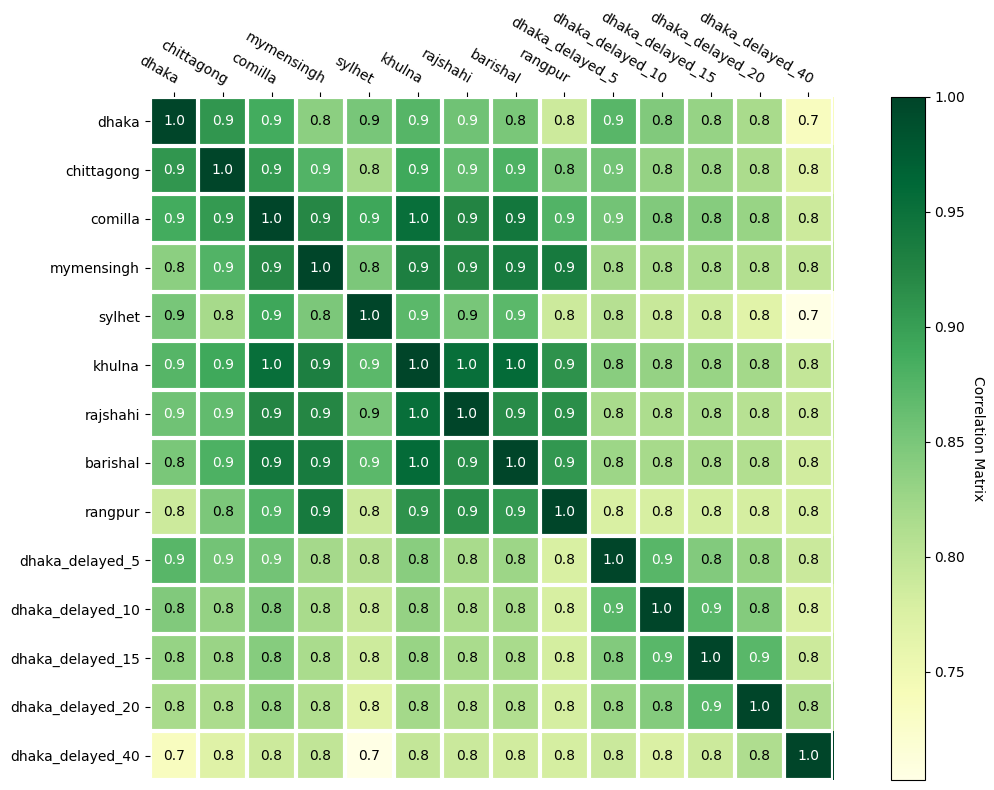

In [ ]:
## Correlation of Dhaka with other features including delayed time lag

columns = ['dhaka', 'chittagong', 'comilla', 'mymensingh',
       'sylhet', 'khulna', 'rajshahi', 'barishal', 'rangpur',
       'dhaka_delayed_5','dhaka_delayed_10','dhaka_delayed_15','dhaka_delayed_20','dhaka_delayed_40']
matrix = df[columns][:-40].corr()

fig, ax = plt.subplots(figsize = (12,8))

im, cbar = heatmap(matrix, columns, columns, ax=ax,
                   cmap="YlGn", cbarlabel="Correlation Matrix")
texts = annotate_heatmap(im, valfmt="{x:.1f}")

fig.tight_layout()
plt.savefig('corr_dhaka.png', dpi = 500)
plt.show()


In [ ]:
df['chittagong_delayed_5'] = pd.Series(df['chittagong'][5:].values)
df['chittagong_delayed_10'] = pd.Series(df['chittagong'][10:].values)
df['chittagong_delayed_15'] = pd.Series(df['chittagong'][15:].values)
df['chittagong_delayed_20'] = pd.Series(df['chittagong'][20:].values)
df['chittagong_delayed_40'] = pd.Series(df['chittagong'][40:].values)

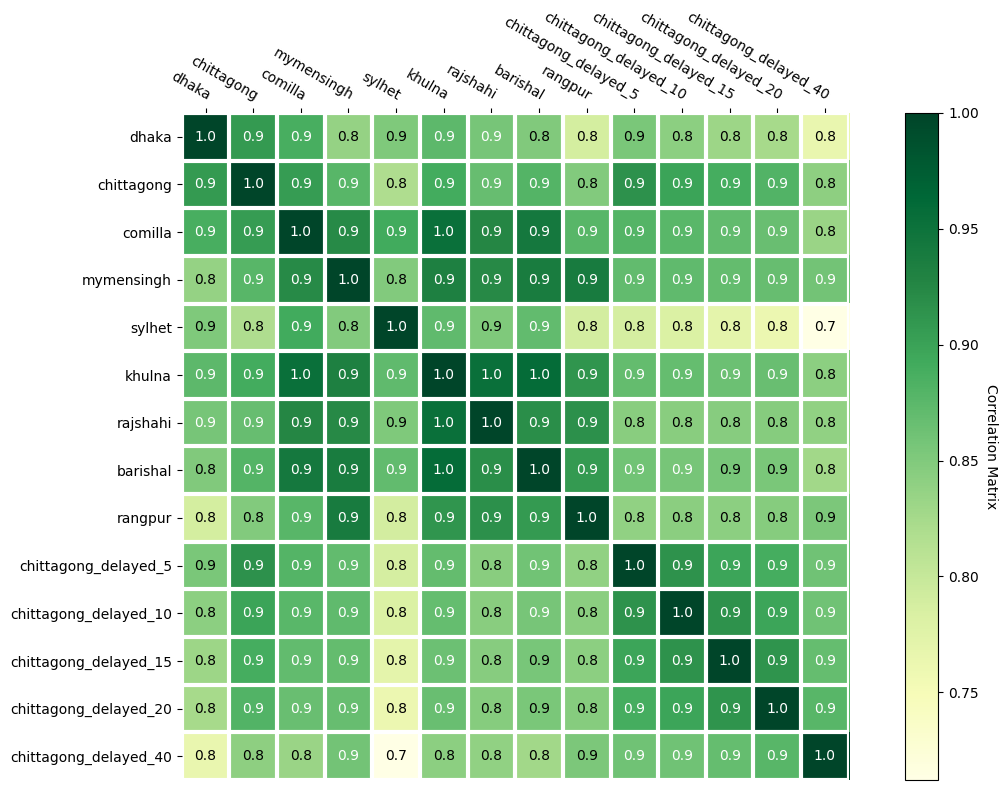

In [ ]:
## Correlation of Dhaka with other features including delayed time lag

columns = ['dhaka', 'chittagong', 'comilla', 'mymensingh',
       'sylhet', 'khulna', 'rajshahi', 'barishal', 'rangpur',
       'chittagong_delayed_5','chittagong_delayed_10','chittagong_delayed_15','chittagong_delayed_20','chittagong_delayed_40']
matrix = df[columns][:-40].corr()

fig, ax = plt.subplots(figsize = (12,8))

im, cbar = heatmap(matrix, columns, columns, ax=ax,
                   cmap="YlGn", cbarlabel="Correlation Matrix")
texts = annotate_heatmap(im, valfmt="{x:.1f}")

fig.tight_layout()
plt.savefig('corr_chittagong.png', dpi = 500)
plt.show()


### ***Interpolation***

In [5]:
interpolation = True
df

,Unnamed: 0.1,Unnamed: 0,dates,dhaka,chittagong,comilla,mymensingh,sylhet,khulna,rajshahi,...,rangpur_relative_humidity,dhaka_temperature,chittagong_temperature,comilla_temperature,mymensingh_temperature,sylhet_temperature,khulna_temperature,rajshahi_temperature,barishal_temperature,rangpur_temperature
0,0,0,1/1/2014,1763.00,565.0,407.0,327.0,243.0,635.0,555.0,...,69.81,17.32,17.65,16.74,17.55,17.55,16.30,16.31,17.40,16.13
1,1,1,1/2/2014,1794.00,530.0,416.0,343.0,251.0,649.0,552.0,...,80.50,18.34,18.33,17.53,17.44,17.38,18.05,17.61,18.30,16.55
2,2,2,1/3/2014,1851.00,569.0,426.0,327.0,239.0,635.0,533.0,...,73.94,16.53,17.32,16.05,15.62,16.12,15.98,14.89,17.19,14.15
3,3,3,1/4/2014,1608.00,507.0,395.0,341.0,258.0,606.0,518.0,...,76.12,15.45,16.50,14.99,16.26,16.71,14.07,13.30,15.74,14.29
4,4,4,1/5/2014,1794.00,551.0,408.0,344.0,248.0,637.0,532.0,...,72.12,15.92,16.80,15.62,16.40,16.24,15.20,14.48,15.97,14.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3271,3271,3271,12/16/2022,3514.88,1032.9,794.0,766.0,358.0,1102.3,934.3,...,61.81,17.94,19.05,17.75,18.78,20.21,17.15,16.11,18.51,17.23
3272,3272,3272,12/17/2022,2520.53,854.0,646.0,674.0,326.0,986.8,837.4,...,67.19,18.55,19.78,18.10,20.44,20.86,16.94,16.78,18.66,18.83
3273,3273,3273,12/18/2022,3246.30,950.7,796.0,751.0,355.0,1070.2,911.0,...,72.00,19.52,20.54,19.62,19.71,20.39,18.12,18.85,19.32,20.25
3274,3274,3274,12/19/2022,3314.50,998.6,785.0,756.0,351.0,1090.0,919.7,...,66.38,19.81,21.33,19.55,20.70,20.90,19.44,18.85,20.25,20.75


In [6]:
df.set_index('dates', inplace = True)
df.index = pd.to_datetime(df.index)
cols = df.columns.to_list()

In [7]:
df2 = pd.DataFrame(columns = cols)
df2['dates'] = pd.date_range(start ='2014-01-01 00:00:00', end = '2022-12-20 23:00:00', freq = 'H')
df2.set_index('dates', inplace = True)

for i in df.index:
  df2.loc[i] = df.loc[i]

In [8]:
temp1 = df2[['dhaka', 'chittagong', 'comilla', 'mymensingh','sylhet', 'khulna', 'rajshahi', 'barishal', 'rangpur']].astype('float').interpolate(method='time', axis = 'index')
temp2 = df2[['es_dhaka', 'es_chittagong', 'es_comilla', 'es_mymensingh','es_sylhet', 'es_khulna', 'es_rajshahi', 'es_barishal', 'es_rangpur']].astype('float').interpolate(method='time', axis = 'index')
df2 = pd.concat([temp1, temp2], axis = 1)

In [9]:
df2['month'] = df2.index.month
df2.reset_index(inplace = True)

In [10]:
df_original = df.copy()
df = df2

In [ ]:
df

### ***Scaling***

In [ ]:
df

,dates,dhaka,chittagong,comilla,mymensingh,sylhet,khulna,rajshahi,barishal,rangpur,es_dhaka,es_chittagong,es_comilla,es_mymensingh,es_sylhet,es_khulna,es_rajshahi,es_barishal,es_rangpur,month
0,2014-01-01 00:00:00,1763.000000,565.000000,407.000,327.000000,243.000000,635.000000,555.000,115.000,312.000000,2055.000000,520.000000,564.000000,553.000000,383.000000,322.000000,262.000000,117.00000,330.000000,1
1,2014-01-01 01:00:00,1764.291667,563.541667,407.375,327.666667,243.333333,635.583333,554.875,114.875,311.791667,2057.250000,520.625000,564.750000,553.666667,383.458333,322.333333,262.291667,117.12500,330.333333,1
2,2014-01-01 02:00:00,1765.583333,562.083333,407.750,328.333333,243.666667,636.166667,554.750,114.750,311.583333,2059.500000,521.250000,565.500000,554.333333,383.916667,322.666667,262.583333,117.25000,330.666667,1
3,2014-01-01 03:00:00,1766.875000,560.625000,408.125,329.000000,244.000000,636.750000,554.625,114.625,311.375000,2061.750000,521.875000,566.250000,555.000000,384.375000,323.000000,262.875000,117.37500,331.000000,1
4,2014-01-01 04:00:00,1768.166667,559.166667,408.500,329.666667,244.333333,637.333333,554.500,114.500,311.166667,2064.000000,522.500000,567.000000,555.666667,384.833333,323.333333,263.166667,117.50000,331.333333,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78619,2022-12-20 19:00:00,3377.300000,977.400000,797.000,748.000000,354.000000,1078.200000,901.300,262.560,632.000000,3362.045137,952.408932,1257.100667,1115.361373,949.475924,784.408989,350.596713,285.79771,619.342054,12
78620,2022-12-20 20:00:00,3377.300000,977.400000,797.000,748.000000,354.000000,1078.200000,901.300,262.560,632.000000,3362.045137,952.408932,1257.100667,1115.361373,949.475924,784.408989,350.596713,285.79771,619.342054,12
78621,2022-12-20 21:00:00,3377.300000,977.400000,797.000,748.000000,354.000000,1078.200000,901.300,262.560,632.000000,3362.045137,952.408932,1257.100667,1115.361373,949.475924,784.408989,350.596713,285.79771,619.342054,12
78622,2022-12-20 22:00:00,3377.300000,977.400000,797.000,748.000000,354.000000,1078.200000,901.300,262.560,632.000000,3362.045137,952.408932,1257.100667,1115.361373,949.475924,784.408989,350.596713,285.79771,619.342054,12


In [ ]:
cols = df[['month','dhaka', 'chittagong', 'comilla', 'mymensingh','sylhet', 'khulna', 'rajshahi', 'barishal', 'rangpur']].columns
training_set = df[cols].astype(float).to_numpy()
print('Training set shape == {}'.format(training_set.shape))
print('All timestamps == {}'.format(len(df['dates'].values)))
print('Featured selected: {}'.format(cols))

Training set shape == (78624, 10)
All timestamps == 78624
Featured selected: Index(['month', 'dhaka', 'chittagong', 'comilla', 'mymensingh', 'sylhet',
       'khulna', 'rajshahi', 'barishal', 'rangpur'],
      dtype='object')


In [ ]:
# Scaling Data
mm = MinMaxScaler((0,1))
mm = mm.fit(training_set)
scaled = mm.transform(training_set)

#dhaka
mm_predict = MinMaxScaler((0,1))
mm_predict = mm_predict.fit(training_set[:,1:10])

In [ ]:
test_set = df_original[cols].iloc[-200:].astype(float).to_numpy()
test_scaled = mm.transform(test_set)
scaled = scaled[:-200*24]

In [ ]:
# For Test data
n_future = 7
n_past = 20
step = 1

x_test = []
y_test = []
for i in range(n_past, len(test_scaled) - n_future +1):
    x_test.append(test_scaled[i - n_past:i:step, 0: test_scaled.shape[-1]])
    y_test.append(test_scaled[i + n_future - 1,1:10])

x_test, y_test = np.array(x_test), np.array(y_test)

print('x_test shape == {}.'.format(x_test.shape))
print('y_test shape == {}.'.format(y_test.shape))

x_test shape == (174, 20, 10).
y_test shape == (174, 9).


### Train Test Split (Manual)


In [ ]:
# Creating a data structure with 90 timestamps and 1 output
x_train = []
y_train = []

if interpolation == True:
  n_future = 7*24  # Number of days we want top predict into the future 
  n_past = 20*24 # Number of past days we want to use to predict the future
  step = 24 # Step size default  1
else:
  n_future = 7
  n_past = 20
  step = 1


for i in range(n_past, len(scaled) - n_future +1):
    x_train.append(scaled[i - n_past:i:step, 0: scaled.shape[-1]])
    y_train.append(scaled[i + n_future - 1,1:10])

    
x_train, y_train = np.array(x_train), np.array(y_train)

print('x_train shape == {}.'.format(x_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

x_train shape == (73177, 20, 10).
y_train shape == (73177, 9).


In [ ]:
# Train Test Split
train_val_split = int(len(x_train)*0.9)
x_val = x_train[train_val_split:]
y_val = y_train[train_val_split:]

x_train = x_train[:train_val_split]
y_train = y_train[:train_val_split]

print('x_train shape == {}.'.format(x_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

print('x_val shape == {}.'.format(x_val.shape))
print('y_val shape == {}.'.format(y_val.shape))


x_train shape == (65859, 20, 10).
y_train shape == (65859, 9).
x_val shape == (7318, 20, 10).
y_val shape == (7318, 9).


### Train Test Split (Generator)

In [ ]:
## Debugging Array
#a = np.array([[1,2,3,4,5],[2,3,4,5,6],[3,4,5,6,7],
#              [4,5,6,7,8],[5,6,7,8,9],[6,7,8,9,10],
#              [7,8,9,10,11],[8,9,10,11,12],[9,10,11,12,13],
#              [10,11,12,13,14],[11,12,13,14,15],[12,13,14,15,16]])

In [ ]:
gen = True

def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=32, step=24):
  if max_index is None:
    max_index = len(data)- delay #8
  i = min_index + lookback
  while 1:
    if shuffle:
      rows = np.random.randint(min_index + lookback, max_index+1, size=batch_size)
    else:
      if i + batch_size-1 > max_index: #+ batch_size 
          i = min_index + lookback
      rows = np.arange(i, min(i + batch_size, max_index+1))
      i += 1
    samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
    targets = np.zeros((len(rows),data.shape[-1]-1))
    for j, row in enumerate(rows):
        indices = range(rows[j] - lookback, rows[j], step)
        samples[j] = data[indices]
        targets[j] = data[rows[j]+ delay-1][1:] # + delay-1
    yield samples, [k for k in targets.T]

In [ ]:
train_test_split = int(len(scaled)*0.8)
train_gen = generator(scaled[:train_test_split],
                      lookback=n_past,
                      delay=n_future,
                      min_index=0,
                      max_index=None, 
                      shuffle=True, 
                      step=24,
                      batch_size = 32)

val_gen = generator(scaled[train_test_split:],
                      lookback=n_past,
                      delay=n_future,
                      min_index=0,
                      max_index=None, 
                      shuffle=True, 
                      step=24,
                      batch_size = 32)

# Model Definition

### Transformer-Encoder

In [ ]:
def transformer_encoder(inputs, head_size, n_heads, fcl_dim, dropout):
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=n_heads, dropout=dropout)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    residual = x + inputs

    x = layers.Dense(fcl_dim, activation = layers.LeakyReLU())(residual)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1], activation = layers.LeakyReLU())(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x+residual


### Transformer

In [ ]:
def build_model(input_shape, head_size, n_heads, fcl_dim, n_transformer, dropout):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(n_transformer):
        x = transformer_encoder(x, head_size, n_heads, fcl_dim, dropout)
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    outputs = [layers.Dense(1, name = divs[i])(x) for i in range(n_divs)]
    return keras.Model(inputs, outputs)

input_shape = (x_train.shape[1],x_train.shape[-1])
model_name = 'Transformer'

model = build_model(
    input_shape,
    head_size=3,
    n_heads=3,
    fcl_dim=32, 
    n_transformer=2,
    dropout=0.1,
)

model.compile(
    loss=['mse' for i in range(n_divs)],
    optimizer=keras.optimizers.Adam(learning_rate=1e-5)
)


In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 20, 10)]     0           []                               
                                                                                                  
 multi_head_attention_3 (MultiH  (None, 20, 10)      397         ['input_4[0][0]',                
 eadAttention)                                                    'input_4[0][0]']                
                                                                                                  
 dropout_9 (Dropout)            (None, 20, 10)       0           ['multi_head_attention_3[0][0]'] 
                                                                                                  
 layer_normalization_6 (LayerNo  (None, 20, 10)      20          ['dropout_9[0][0]']        

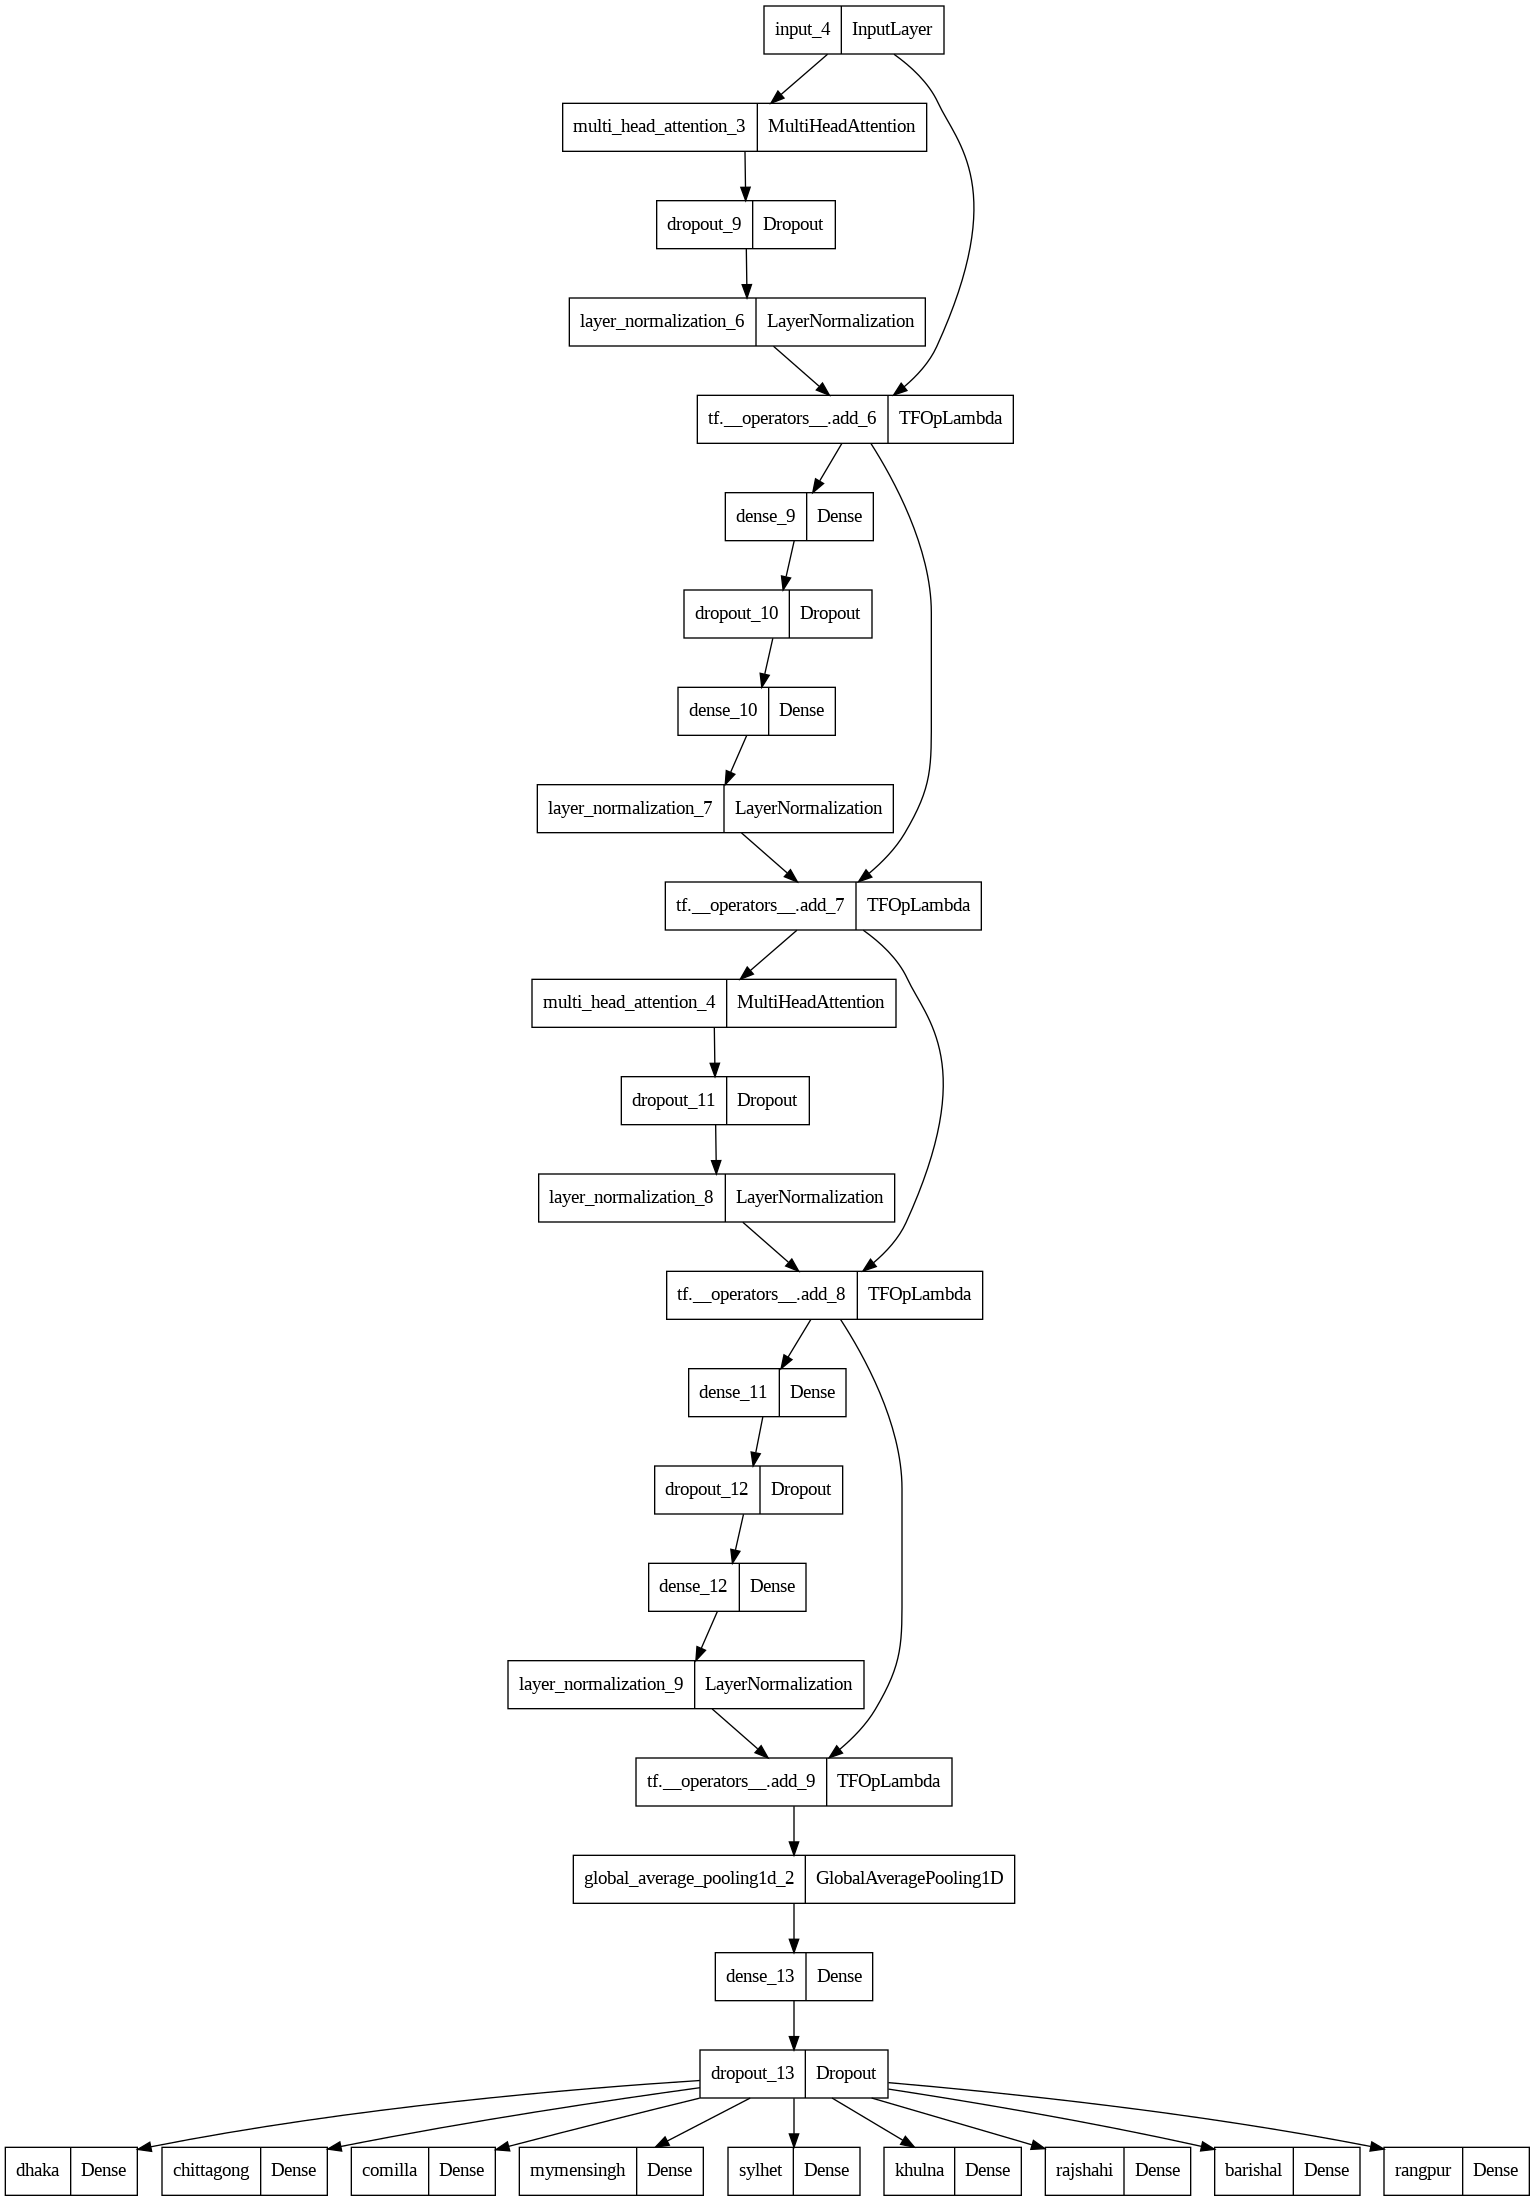

In [ ]:
keras.utils.plot_model(model)

### Transformer-LSTM

In [ ]:
def build_model(input_shape, head_size, n_heads, fcl_dim, n_transformer, dropout):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(n_transformer):
        x = transformer_encoder(x, head_size, n_heads, fcl_dim, dropout)

    #x = layers.LSTM(64, activation = 'tanh', dropout = dropout, return_sequences=True)(x)
    x = layers.LSTM(32, activation = 'tanh', dropout = dropout)(x)
    x = layers.Dense(20, activation="relu")(x)
    #x = layers.Dropout(dropout)(x)
    #x = layers.Dense(20, activation='relu')(x)
    outputs = [layers.Dense(1, name = divs[i])(x) for i in range(n_divs)]
    return keras.Model(inputs, outputs)

input_shape = (x_train.shape[1],x_train.shape[-1])
model_name = 'Transformer_LSTM'

model = build_model(
    input_shape,
    head_size=3,
    n_heads=3, 
    fcl_dim=32, 
    n_transformer=1,
    dropout=0.1,
)

model.compile(
    loss=['mse' for i in range(n_divs)],
    optimizer=keras.optimizers.Adam(learning_rate=1e-5)
)


In [ ]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 20, 10)]     0           []                               
                                                                                                  
 multi_head_attention_6 (MultiH  (None, 20, 10)      397         ['input_8[0][0]',                
 eadAttention)                                                    'input_8[0][0]']                
                                                                                                  
 dropout_15 (Dropout)           (None, 20, 10)       0           ['multi_head_attention_6[0][0]'] 
                                                                                                  
 layer_normalization_12 (LayerN  (None, 20, 10)      20          ['dropout_15[0][0]']       

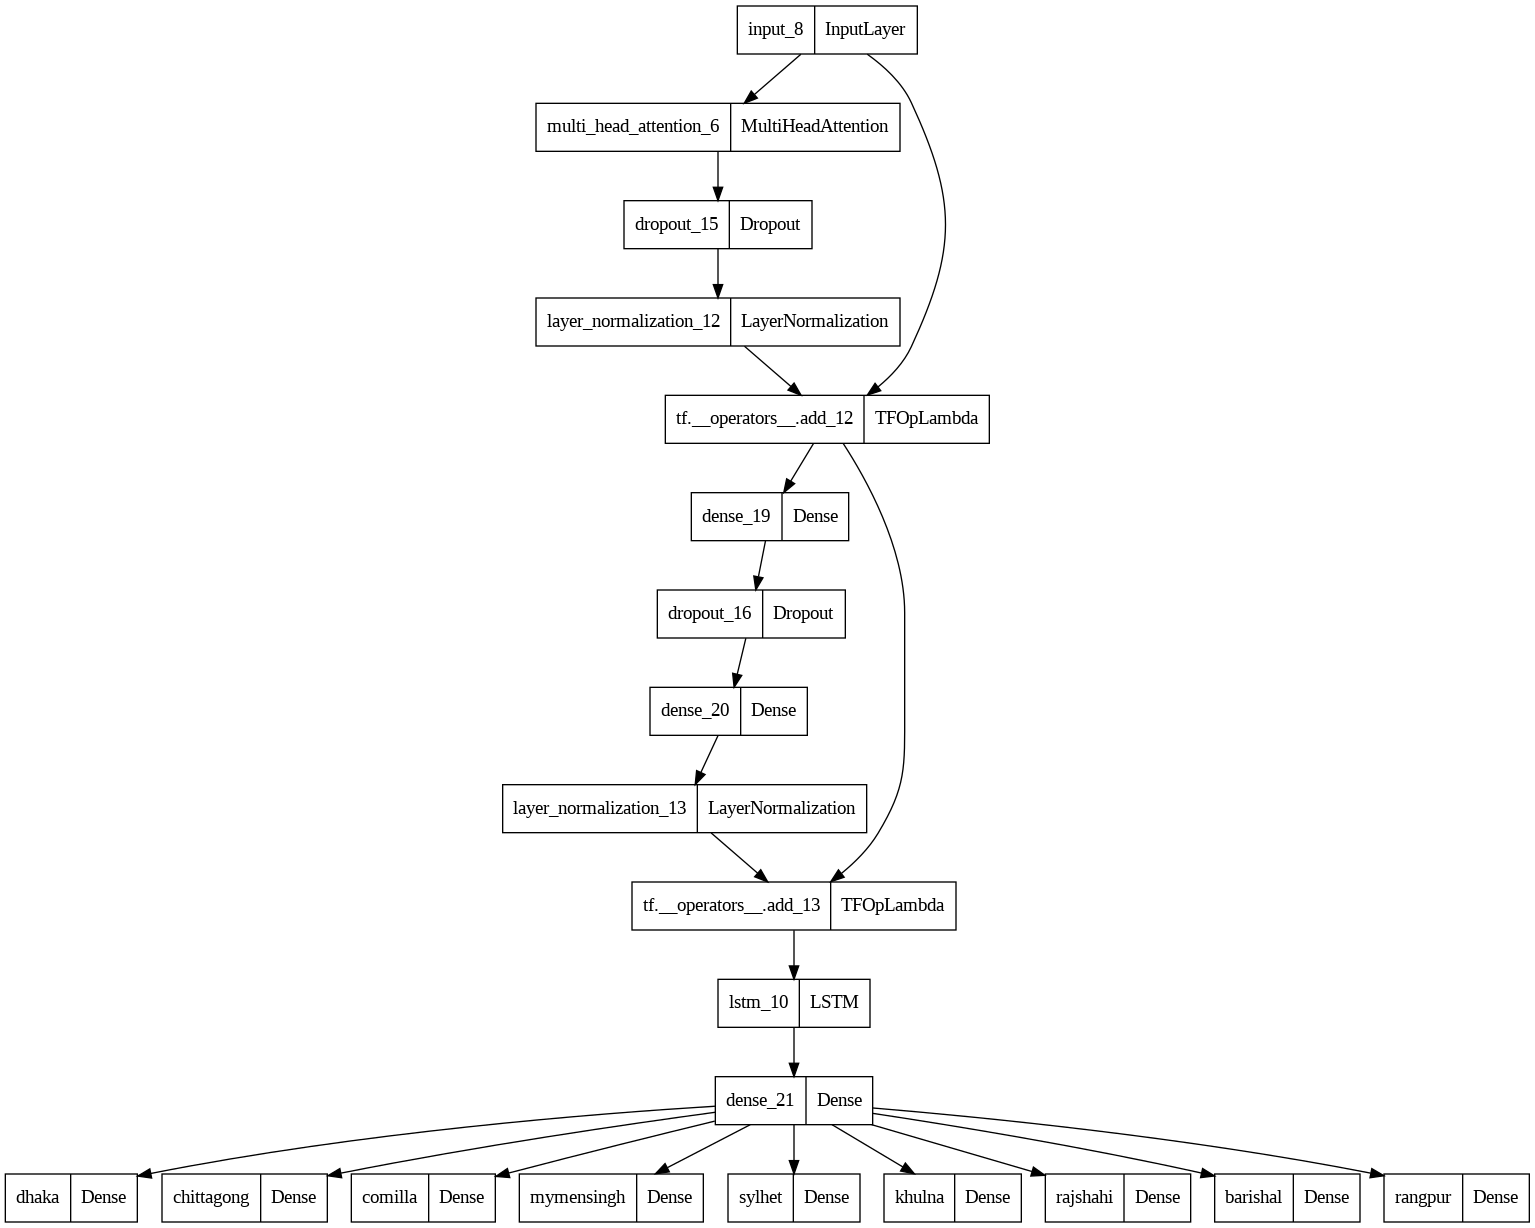

In [ ]:
keras.utils.plot_model(model)

### CNN-Transformer

In [ ]:
def build_model(input_shape, head_size, n_heads, fcl_dim, n_transformer, dropout=0):
    inputs = keras.Input(shape=input_shape)
    
    x = inputs
    x = layers.Conv1D(64, 3, activation=layers.LeakyReLU())(x)
    x = layers.MaxPooling1D(2)(x)
    #x = keras.backend.permute_dimensions(x,(0,2,1))
    for _ in range(n_transformer):
        x = transformer_encoder(x, head_size, n_heads, fcl_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    x = layers.Dense(32, activation=layers.LeakyReLU())(x)
    x = layers.Dropout(dropout)(x)
    outputs = [layers.Dense(1, name = divs[i])(x) for i in range(n_divs)]
    return keras.Model(inputs, outputs)

input_shape = (x_train.shape[1],x_train.shape[-1])

model_name = 'CNN_Transformer'
model = build_model(
    input_shape,
    head_size=16,
    n_heads=4, 
    fcl_dim=32, 
    n_transformer=1,
    dropout=0.1,
)

model.compile(
    loss=['mse' for i in range(n_divs)],
    optimizer=keras.optimizers.Adam(learning_rate=1e-5)
)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 20, 10)]     0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 18, 64)       1984        ['input_2[0][0]']                
                                                                                                  
 max_pooling1d_1 (MaxPooling1D)  (None, 9, 64)       0           ['conv1d_1[0][0]']               
                                                                                                  
 multi_head_attention (MultiHea  (None, 9, 64)       16640       ['max_pooling1d_1[0][0]',        
 dAttention)                                                      'max_pooling1d_1[0][0]']  

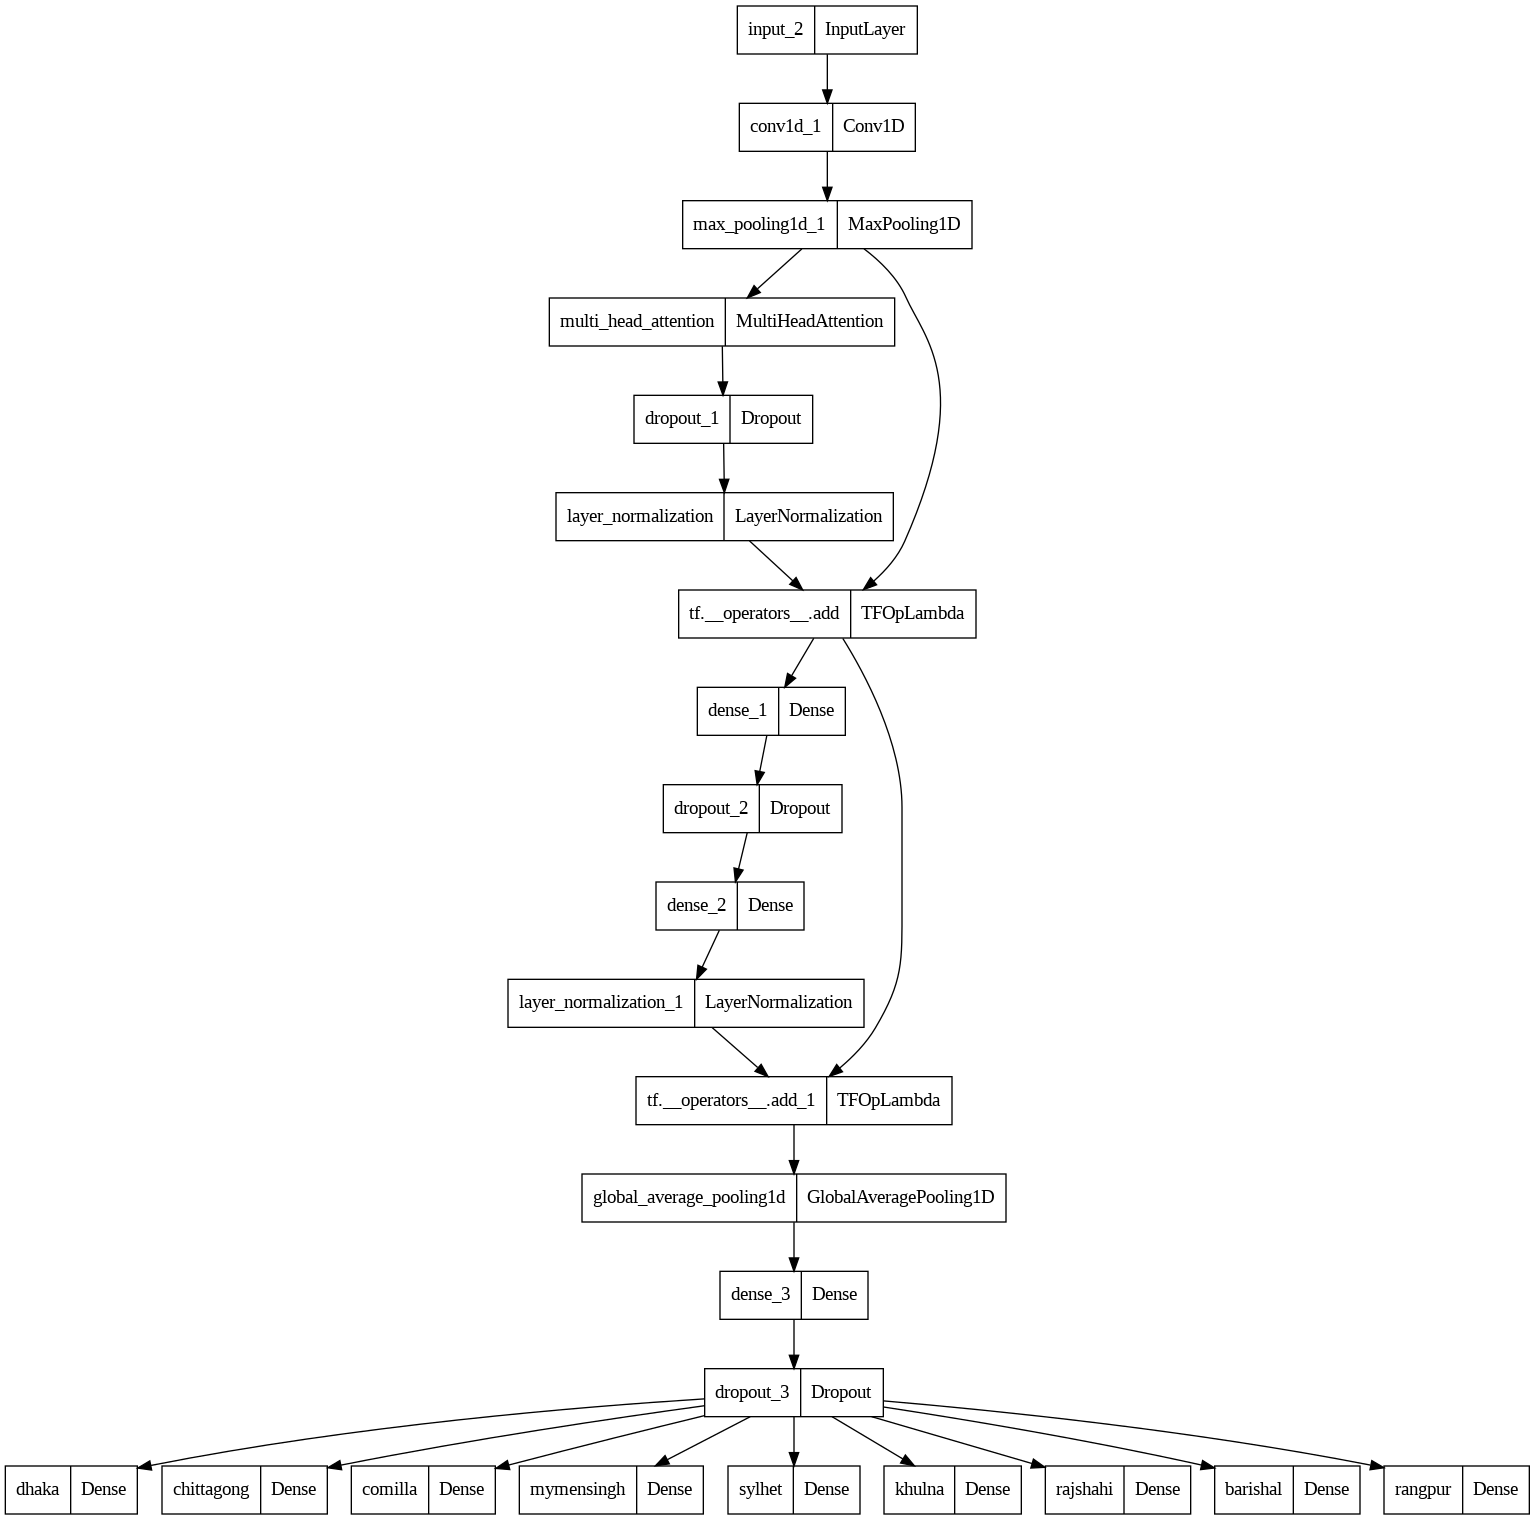

In [ ]:
keras.utils.plot_model(model)

### LSTM

In [ ]:
def build_model(
    input_shape,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    x = layers.LSTM(128, activation = 'tanh',return_sequences=True)(x)
    x = layers.LSTM(64, activation = 'tanh')(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)
    outputs = [layers.Dense(1, name = divs[i])(x) for i in range(n_divs)]
    return keras.Model(inputs, outputs)


input_shape = (x_train.shape[1],x_train.shape[-1])

model_name = 'LSTM'
model = build_model(
    input_shape,
    mlp_dropout=0.2,
    dropout=0.2,
)

model.compile(
    loss=['mse' for i in range(n_divs)],
    optimizer=keras.optimizers.Adam(learning_rate=1e-5) 
)

In [ ]:
model.summary()

In [ ]:
keras.utils.plot_model(model)

### CNN-LSTM

In [ ]:
def build_model(
    input_shape,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    x = layers.Conv1D(128, 3, activation='relu')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.LSTM(64, activation = 'tanh',return_sequences=True)(x)
    x = layers.LSTM(64, activation = 'tanh')(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)
    outputs = [layers.Dense(1, name = divs[i])(x) for i in range(n_divs)]
    return keras.Model(inputs, outputs)


input_shape = (x_train.shape[1],x_train.shape[-1])

model_name = 'CNN_LSTM'
model = build_model(
    input_shape,
    mlp_dropout=0.1,
    dropout=0.1,
)

model.compile(
    loss=['mse' for i in range(n_divs)],
    optimizer=keras.optimizers.Adam(learning_rate=1e-5) 
)

In [ ]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 20, 10)]     0           []                               
                                                                                                  
 conv1d_2 (Conv1D)              (None, 18, 128)      3968        ['input_10[0][0]']               
                                                                                                  
 max_pooling1d_2 (MaxPooling1D)  (None, 9, 128)      0           ['conv1d_2[0][0]']               
                                                                                                  
 lstm_11 (LSTM)                 (None, 9, 64)        49408       ['max_pooling1d_2[0][0]']        
                                                                                            

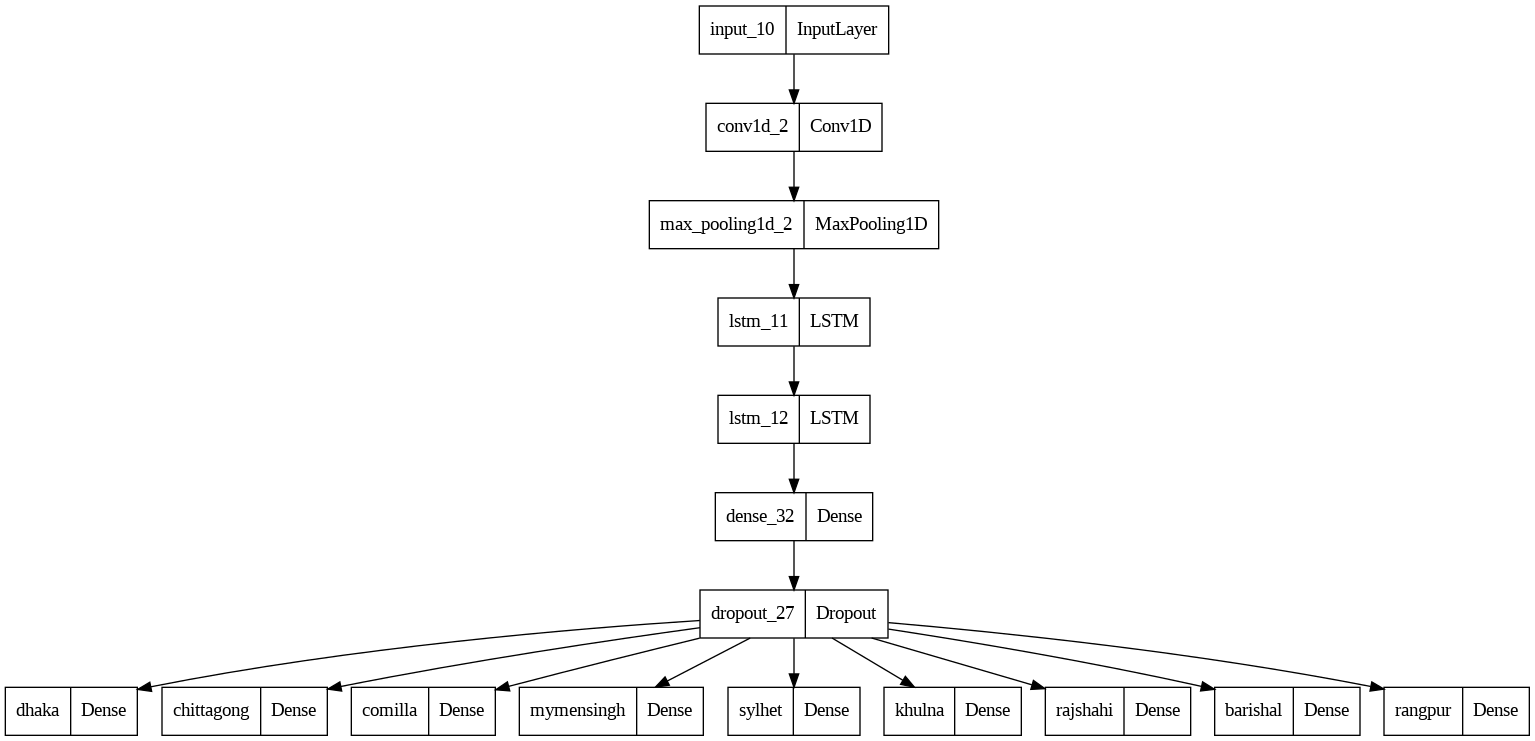

In [ ]:
keras.utils.plot_model(model)

### GRU

In [ ]:
def build_model(
    input_shape,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    x = layers.GRU(128, activation = 'tanh',return_sequences=True)(x)
    x = layers.GRU(64, activation = 'tanh')(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)
    outputs = [layers.Dense(1, name = divs[i])(x) for i in range(n_divs)]
    return keras.Model(inputs, outputs)


input_shape = (x_train.shape[1],x_train.shape[-1])

model_name = 'GRU'
model = build_model(
    input_shape,
    mlp_dropout=0.1,
    dropout=0.1,
)

model.compile(
    loss=['mse' for i in range(n_divs)],
    optimizer=keras.optimizers.Adam(learning_rate=1e-5) 
)

In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 20, 10)]     0           []                               
                                                                                                  
 gru_2 (GRU)                    (None, 20, 128)      53760       ['input_6[0][0]']                
                                                                                                  
 gru_3 (GRU)                    (None, 64)           37248       ['gru_2[0][0]']                  
                                                                                                  
 dense_17 (Dense)               (None, 32)           2080        ['gru_3[0][0]']                  
                                                                                            

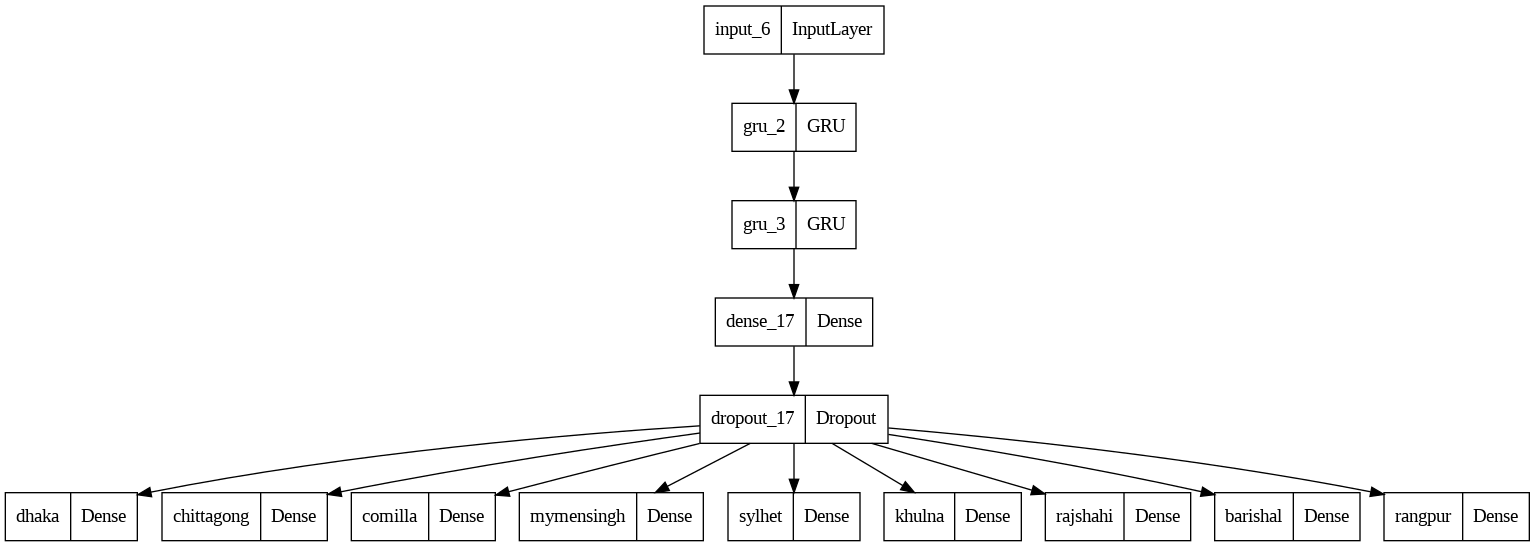

In [ ]:
keras.utils.plot_model(model)

### CNN GRU

In [ ]:
def build_model(
    input_shape,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    x = layers.Conv1D(128, 3, activation='relu')(x)
    x = layers.MaxPooling1D(2)(x)
    #x = layers.GRU(64, activation = 'tanh',return_sequences=True)(x)
    x = layers.GRU(64, activation = 'tanh')(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)
    outputs = [layers.Dense(1, name = divs[i])(x) for i in range(n_divs)]
    return keras.Model(inputs, outputs)


input_shape = (x_train.shape[1],x_train.shape[-1])

model_name = 'CNN_GRU'
model = build_model(
    input_shape,
    mlp_dropout=0.1,
    dropout=0.1,
)

model.compile(
    loss=['mse' for i in range(n_divs)],
    optimizer=keras.optimizers.Adam(learning_rate=1e-5) 
)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 10)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 18, 128)      3968        ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 9, 128)       0           ['conv1d[0][0]']                 
                                                                                                  
 gru (GRU)                      (None, 64)           37248       ['max_pooling1d[0][0]']          
                                                                                              

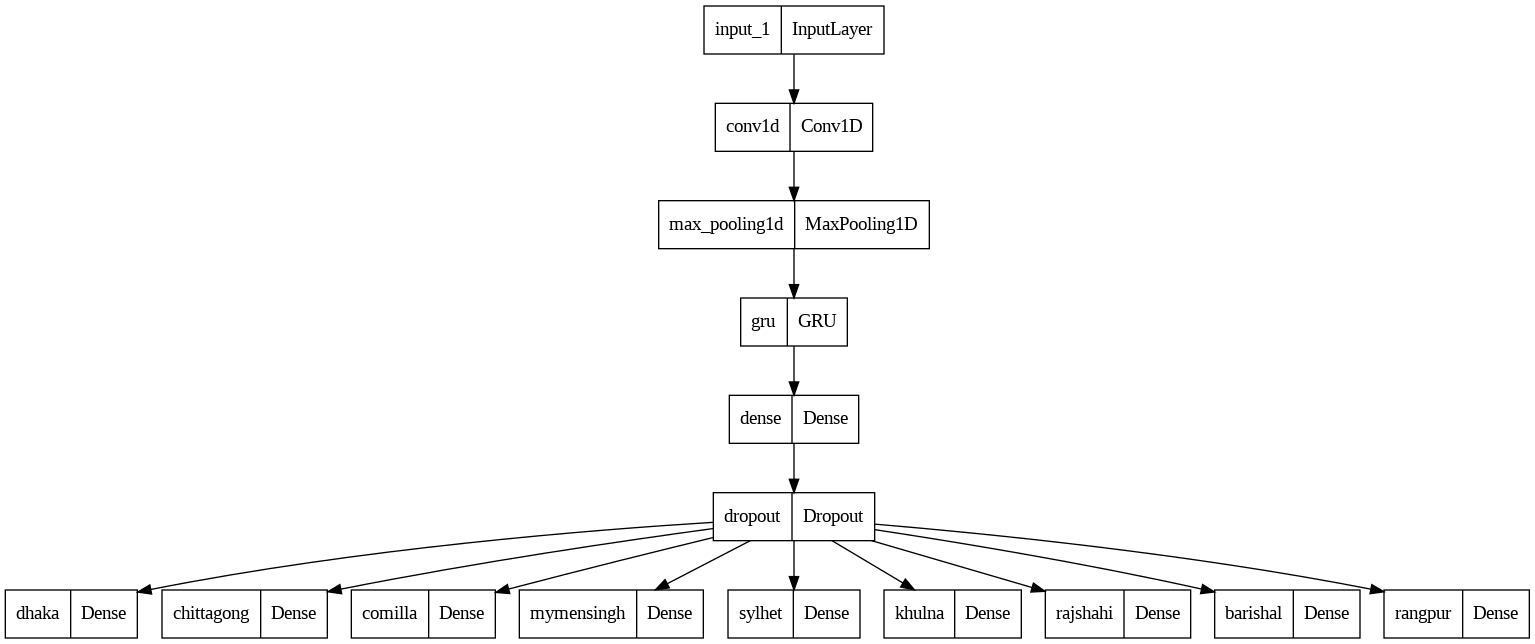

In [ ]:
keras.utils.plot_model(model)

# Model Training

In [ ]:
callbacks = [keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)] #patience = 10

if gen == True:
  pass
else:
  history= model.fit(
    x_train,
    [i for i in y_train.T],
    shuffle = True,
    validation_data = (x_val,[k for k in y_val.T]),
    #validation_split = 0.2,
    epochs= 50,
    callbacks= callbacks
    )

Epoch 1/50
2059/2059 [==============================] - 52s 19ms/step - loss: 1.4751 - dhaka_loss: 0.1709 - chittagong_loss: 0.3151 - comilla_loss: 0.2185 - mymensingh_loss: 0.1773 - sylhet_loss: 0.1075 - khulna_loss: 0.2111 - rajshahi_loss: 0.0935 - barishal_loss: 0.0234 - rangpur_loss: 0.1578 - val_loss: 1.7093 - val_dhaka_loss: 0.2393 - val_chittagong_loss: 0.3096 - val_comilla_loss: 0.1673 - val_mymensingh_loss: 0.1707 - val_sylhet_loss: 0.1371 - val_khulna_loss: 0.2679 - val_rajshahi_loss: 0.0572 - val_barishal_loss: 0.0367 - val_rangpur_loss: 0.3234
Epoch 2/50
2059/2059 [==============================] - 38s 18ms/step - loss: 0.4160 - dhaka_loss: 0.0613 - chittagong_loss: 0.0503 - comilla_loss: 0.0373 - mymensingh_loss: 0.0322 - sylhet_loss: 0.0546 - khulna_loss: 0.0579 - rajshahi_loss: 0.0194 - barishal_loss: 0.0267 - rangpur_loss: 0.0764 - val_loss: 0.3494 - val_dhaka_loss: 0.0529 - val_chittagong_loss: 0.0483 - val_comilla_loss: 0.0238 - val_mymensingh_loss: 0.0221 - val_sylhe

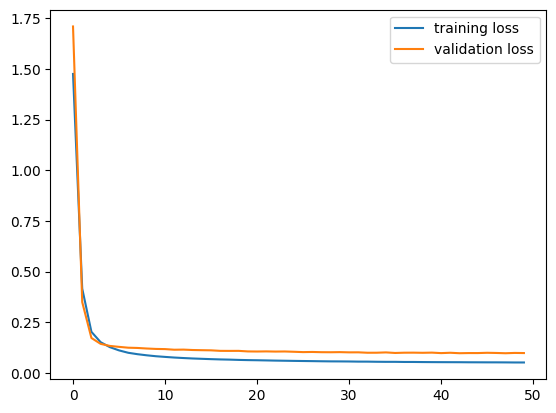

In [ ]:
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()

In [ ]:
model_name

'Transformer'

In [ ]:
hist_df = pd.DataFrame(history.history)
loss = []
val_loss = []
for i in range(hist_df.shape[0]):
  loss.append(sum(hist_df.iloc[i,1:10])/9)
  val_loss.append(sum(hist_df.iloc[i,11:20])/9)

loss , val_loss = np.array(loss), np.array(val_loss)

In [ ]:
hist_df.to_excel('/content/drive/MyDrive/ColabWorks/LF_MultiHead/'+model_name+'/history.xlsx')

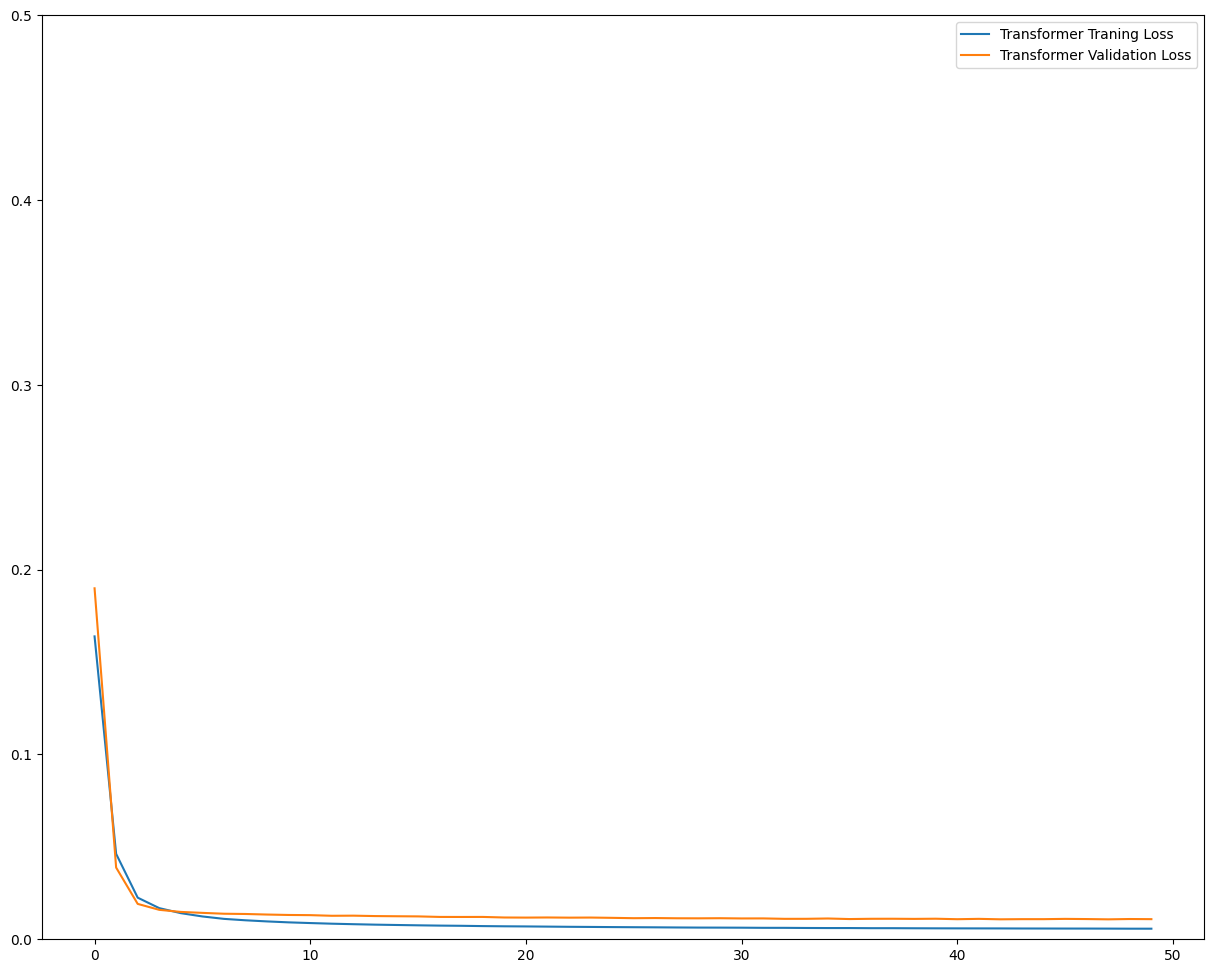

In [ ]:
plt.figure(figsize = [15,12])
plt.plot(loss,label = model_name + " Traning Loss")
plt.plot(val_loss, label = model_name + " Validation Loss")
plt.legend()
plt.ylim((0,0.5))
plt.savefig('/content/drive/MyDrive/ColabWorks/LF_MultiHead/'+model_name+'/model.png', dpi = 500)
plt.show()

# Prediction And Plotting

In [ ]:
model_name = 'Transformer'

In [ ]:
#model.save('/content/drive/MyDrive/ColabWorks/LF_MultiHead/'+model_name+'/'+model_name+'52.h5')
#model = keras.models.load_model('/content/drive/MyDrive/ColabWorks/LF_MultiHead/'+model_name+'/'+model_name+'.h5')
#model = keras.models.load_model('/content/drive/MyDrive/ColabWorks/LF_MultiHead/AB_Models/'+model_name+'.h5')
model = keras.models.load_model('/content/drive/MyDrive/ColabWorks/LF_MultiHead/Final/'+model_name+'/'+model_name+'_AB.h5')


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 20, 10)]     0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 18, 64)       1984        ['input_2[0][0]']                
                                                                                                  
 max_pooling1d_1 (MaxPooling1D)  (None, 9, 64)       0           ['conv1d_1[0][0]']               
                                                                                                  
 multi_head_attention (MultiHea  (None, 9, 64)       16640       ['max_pooling1d_1[0][0]',        
 dAttention)                                                      'max_pooling1d_1[0][0]']  

In [ ]:
real_train = mm_predict.inverse_transform(y_train)
real_val = mm_predict.inverse_transform(y_val)
predicted_train = mm_predict.inverse_transform(np.squeeze(np.array(model.predict(x_train))).T)
predicted_val = mm_predict.inverse_transform(np.squeeze(np.array(model.predict(x_val))).T)

229/229 [==============================] - 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


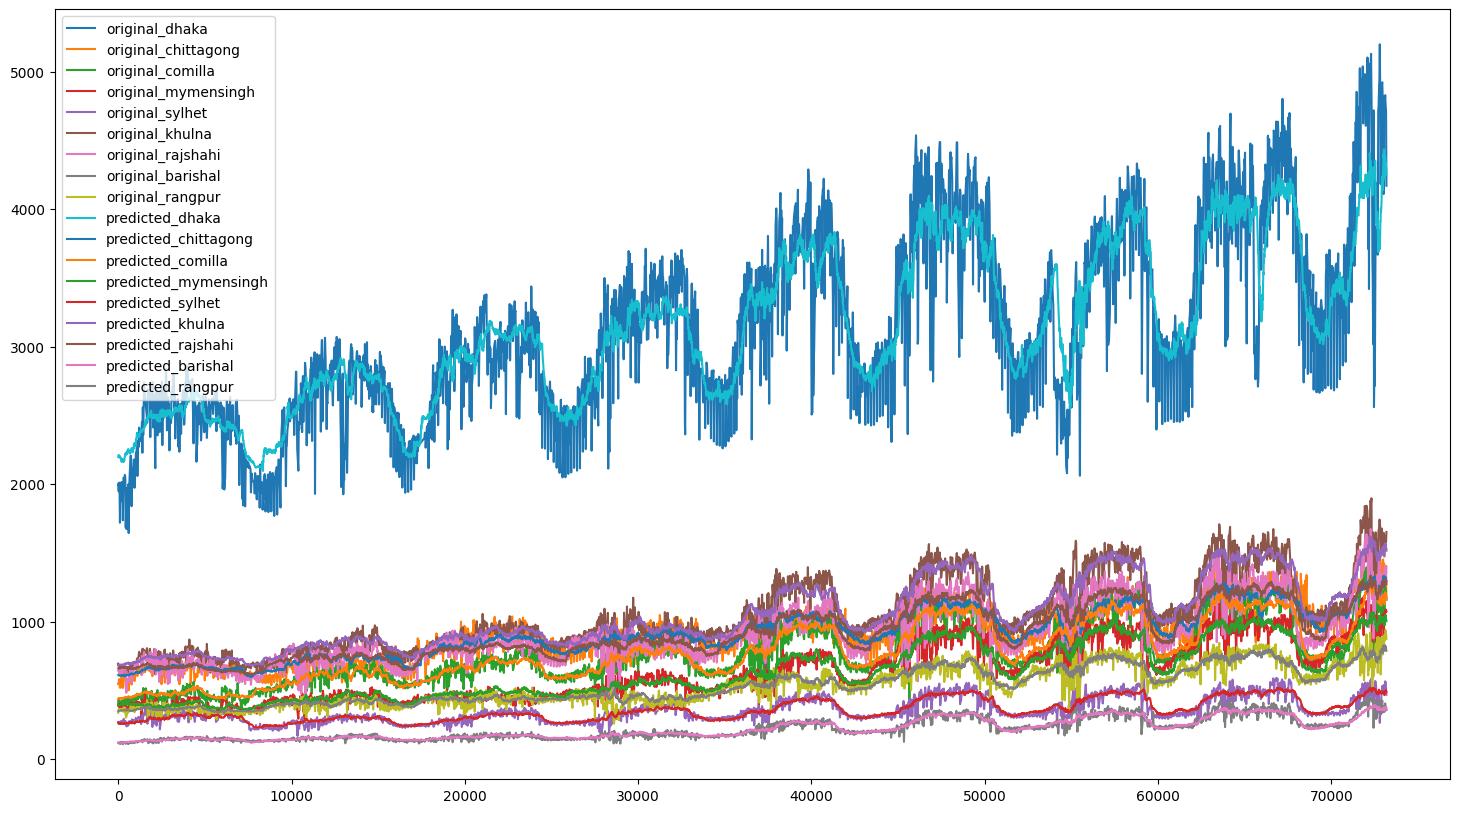

In [ ]:
plt.figure(figsize = [18,10])
plt.plot(np.concatenate((real_train, real_val)), label = ['original_'+i for i in divs])
plt.plot(np.concatenate((predicted_train,predicted_val)), label = ['predicted_'+i for i in divs])
plt.legend()
plt.show()

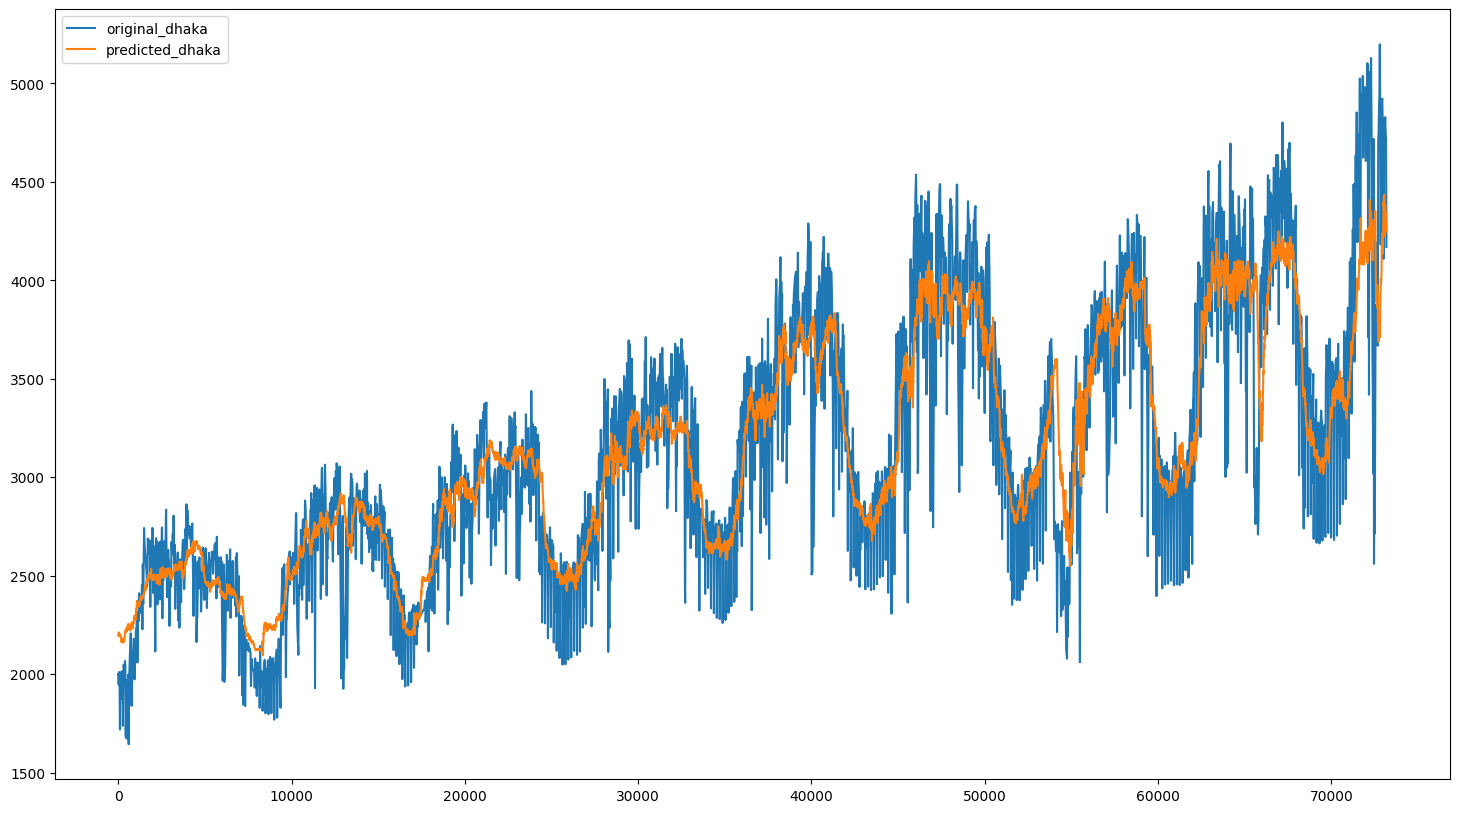

In [ ]:
idx = divs.index('dhaka')
plt.figure(figsize = [18,10])
plt.plot(np.concatenate((real_train[:,idx], real_val[:,idx])), label = 'original_'+divs[idx])
plt.plot(np.concatenate((predicted_train[:,idx],predicted_val[:,idx])), label = 'predicted_'+divs[idx])
#plt.plot(real_test[:,idx])
#plt.plot(predicted_test[:,idx])
plt.legend()
plt.show()

In [ ]:
## Test data
real = mm_predict.inverse_transform(y_test)
predicted = mm_predict.inverse_transform(np.squeeze(np.array(model.predict(x_test))).T)

# finding the mape
for i in range(len(divs)):
  print('{} division\t: MAPE {}, RMSE {}'.format(divs[i],mean_absolute_percentage_error(real[:,i], predicted[:,i]),
                                            np.sqrt(mean_squared_error(real[:,i], predicted[:,i]))))

6/6 [==============================] - 0s 6ms/step
dhaka division	: MAPE 0.09398987812775589, RMSE 469.0362156429295
chittagong division	: MAPE 0.06805855035694233, RMSE 107.02612888029267
comilla division	: MAPE 0.07611932091541744, RMSE 108.39559850652135
mymensingh division	: MAPE 0.09225261248809528, RMSE 105.59316489439277
sylhet division	: MAPE 0.09339485772233876, RMSE 59.30657938060488
khulna division	: MAPE 0.06199755582944273, RMSE 114.31253121391944
rajshahi division	: MAPE 0.06477187508385449, RMSE 104.30475692562952
barishal division	: MAPE 0.07490460456396723, RMSE 32.67143015499557
rangpur division	: MAPE 0.10920894993339698, RMSE 99.96480076624088


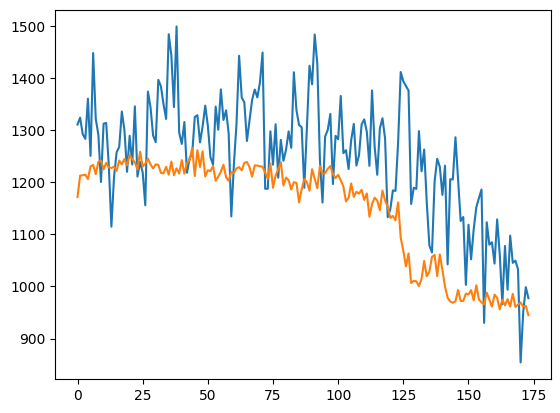

In [ ]:
plt.plot(real[:,1])
plt.plot(predicted[:,1])

In [ ]:
real_df = pd.DataFrame(real, columns = divs)
predicted_df = pd.DataFrame(predicted, columns = divs)

In [ ]:
real_df.to_excel('/content/drive/MyDrive/ColabWorks/LF_MultiHead/Final/'+model_name+'/'+model_name+'_real.xlsx')
predicted_df.to_excel('/content/drive/MyDrive/ColabWorks/LF_MultiHead/Final/'+model_name+'/'+model_name+'_predicted.xlsx')

In [ ]:
model_name

'Transformer'

In [ ]:
real_df

,dhaka,chittagong,comilla,mymensingh,sylhet,khulna,rajshahi,barishal,rangpur
0,4840.00,1310.7,1137.0,1027.0,431.0,1573.4,1351.2,390.96,796.0
1,4656.23,1324.0,1146.0,995.0,400.0,1579.0,1321.4,374.00,829.0
2,4398.24,1292.2,1142.0,1118.0,483.0,1588.4,1371.8,371.86,877.0
3,4712.73,1283.2,1183.0,1067.0,444.0,1578.0,1303.6,378.02,791.0
4,4787.30,1360.3,1249.0,1026.0,466.0,1647.2,1329.5,407.89,777.0
...,...,...,...,...,...,...,...,...,...
169,3514.88,1032.9,794.0,766.0,358.0,1102.3,934.3,223.56,684.0
170,2520.53,854.0,646.0,674.0,326.0,986.8,837.4,216.99,572.0
171,3246.30,950.7,796.0,751.0,355.0,1070.2,911.0,231.56,625.0
172,3314.50,998.6,785.0,756.0,351.0,1090.0,919.7,223.56,644.0
